# Files and libraries

In [1]:
import numpy as np
from math import *
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from time import time
from scipy.optimize import curve_fit
from google.colab import files
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import optimize

In [4]:
uploaded = files.upload()

Saving DATA_ES500.xlsx to DATA_ES500.xlsx
Saving Forward_prices.xlsx to Forward_prices.xlsx
Saving IV.xlsx to IV.xlsx


In [5]:
d = pd.read_excel(io.BytesIO(uploaded['DATA_ES500.xlsx']))
fwd = pd.read_excel(io.BytesIO(uploaded['Forward_prices.xlsx']))
IV = pd.read_excel(io.BytesIO(uploaded['IV.xlsx']))

In [ ]:
IV

In [6]:
K = d['Strikes'].to_numpy()
forwards = fwd['Forwards'].to_numpy()
I = IV.to_numpy() #transform DataFrame to a matrix
Strike = K.tolist()


In [7]:
start_date= '04/11/2019'
start_date = pd.to_datetime(start_date)
#Maturities
T = []



for i in range(18):
  end = pd.to_datetime(IV.columns.values[i])
  maturity = (end - start_date)
  T.append(float(maturity.days)/365)

# Option prices from implied volatility, Black-Scholes

In [9]:
def d1(s0,k,r,sigma,T):
    return (np.log(s0/k)+(r+sigma**2/2)*T)/(sigma*np.sqrt(T))

def d2(s0,k,r,sigma,T):
     return (np.log(s0/k)+(r-sigma**2/2)*T)/(sigma*np.sqrt(T))
    
def BS(s0,k,r,sigma,T):
    return s0*ss.norm.cdf(d1(s0,k,r,sigma,T))-k*np.exp(-r*T)*ss.norm.cdf(d2(s0,k,r,sigma,T))

In [10]:
prices = np.zeros((51,18))

for i in range(len(IV)):
  for j in range(len(forwards)):
    prices[i][j] = BS(forwards[j],K[i],0,I[i][j],T[j]) #Black model, r = 0

BS_price = pd.DataFrame(prices)

In [ ]:
x = T
y = K
X,Y = np.meshgrid(x,y)
Z = BS_price
fig = plt.figure()
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(Y,X,Z)

# From implied to local vol through Dupire

In [14]:
y = np.zeros((51,18))

for i in range(51):
  y[i] = np.log(K[i]/forwards)

I = IV.to_numpy() #transform DataFrame to a matrix

Local_var = np.zeros((50,17))

Local_vol = np.zeros((50,17))

didt = np.zeros((50,17)) #derivative of implied with respect to time
didy = np.zeros((50,17)) #derivate of IV with respect to y
didy2 = np.zeros((50,17)) #2nd derivative of IV respect to y

for i in range(0,len(IV)-1):
  for j in range(17):
    didt[i][j] = (I[i][j+1] - I[i][j]) / (T[j+1] - T[j])
    didy[i][j] = (I[i+1][j] - I[i][j]) / (y[i+1][j]-y[i][j]) 
    didy2[i][j] = (I[i+1][j]-I[i-1][j] + 2*I[i][j])/ ((y[i+1][j]-y[i][j])**2) 
    
    Local_var[i][j] = ((2*T[j]*I[i][j]*didt[i][j] + I[i][j]**2)/((1-2*didy[i][j]*y[i][j]/I[i][j] + 2*(T[j]*I[i][j]*didy[i][j])**2*(-1/8-1/(2*T[j]*I[i][j]**2)+y[i][j]**2) + T[j]*I[i][j]*didy2[i][j] + 2*T[j]*didy[i][j]**2)))

    if Local_var[i][j] >=0:
      Local_vol[i][j] = (Local_var[i][j])**.5
    
    else:
      Local_vol[i][j] = (Local_vol[i][j+1] + Local_vol[i][j-1])/2


Local = pd.DataFrame(Local_vol)

In [ ]:
Local

In [18]:
df = Local

In [ ]:
fig,ax= plt.subplots(nrows=3,ncols=3,figsize=(12,8),gridspec_kw={'wspace':0.2,'hspace':0.1},sharex='col',sharey='row')


ax[0,0].plot(K[0:50],df[0],label = 'T = 0.1')
ax[0,0].grid()  
ax[0,0].legend(loc='best')

ax[0,1].plot(K[0:50],df[1],label = 'T = 0.19')
ax[0,1].grid()  
ax[0,1].legend(loc='best')

ax[0,2].plot(K[0:50],df[2],label = 'T = 0.27')
ax[0,2].grid()  
ax[0,2].legend(loc='best')

ax[1,0].plot(K[0:50],df[3],label = 'T = 0.35')
ax[1,0].grid()  
ax[1,0].legend(loc='best')

ax[1,1].plot(K[0:50],df[4],label = 'T = 0.44')
ax[1,1].grid()  
ax[1,1].legend(loc='best')

ax[1,2].plot(K[0:50],df[5],label = 'T = 0.69' )
ax[1,2].grid()  
ax[1,2].legend(loc='best')

ax[2,0].plot(K[0:50],df[6],label = 'T = 0.94')
ax[2,0].grid()  
ax[2,0].legend(loc='best')

ax[2,1].plot(K[0:50],df[7],label = 'T = 1.19')
ax[2,1].grid()  
ax[2,1].legend(loc='best')

ax[2,2].plot(K[0:50],df[8],label = 'T = 1.69')
ax[2,2].grid()  
ax[2,2].legend(loc='best')

plt.setp(ax[-1, :], xlabel='Strikes')
plt.setp(ax[:, 0], ylabel=' Local volatility')

In [ ]:
fig,ax= plt.subplots(nrows=3,ncols=3,figsize=(12,8),gridspec_kw={'wspace':0.2,'hspace':0.1},sharex='col',sharey='row')


ax[0,0].plot(K[1:50],df[9],label = 'T = 2.19 ')
ax[0,0].grid()  
ax[0,0].legend(loc='best')

ax[0,1].plot(K[1:50],df[10],label = 'T = 2.68')
ax[0,1].grid()  
ax[0,1].legend(loc='best')

ax[0,2].plot(K[1:50],df[11],label = 'T = 3.68')
ax[0,2].grid()  
ax[0,2].legend(loc='best')

ax[1,0].plot(K[1:50],df[12],label = 'T = 4.68')
ax[1,0].grid()  
ax[1,0].legend(loc='best')

ax[1,1].plot(K[1:50],df[13],label = 'T = 5.7')
ax[1,1].grid()  
ax[1,1].legend(loc='best')

ax[1,2].plot(K[1:50],df[14],label = 'T = 6.7')
ax[1,2].grid()  
ax[1,2].legend(loc='best')

ax[2,0].plot(K[1:50],df[15],label = 'T = 7.69')
ax[2,0].grid()  
ax[2,0].legend(loc='best')

ax[2,1].plot(K[1:50],df[16],label = 'T = 8.69')
ax[2,1].grid()  
ax[2,1].legend(loc='best')

ax[2,2].grid()

plt.setp(ax[-1, :], xlabel='Strikes')
plt.setp(ax[:, 0], ylabel=' Local volatility')

In [ ]:
x = df.columns
y = df.index
X,Y = np.meshgrid(x,y)
Z = df
fig = plt.figure()
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(Y,X,Z)

# SVI calibration

In [20]:
def SVI_calibration(k,a,b,rho,m,sigma):
  SVI = a+b*(rho*(k-m)+np.sqrt((k-m)**2+sigma**2))
  return SVI

log_strikes = np.log(K)
parameters = np.zeros((5,len(T)))

for i in range(0,len(T)):
  implied_var = (IV.iloc[:,i])**2

  popt,pcov = curve_fit(SVI_calibration,log_strikes,implied_var,p0=(-0.1949410760452949, 0.3340214781169242, -0.013807059032125367, 8.213418579710023, 0.6324108554863928),maxfev = 10000000)

  parameters[:,i] = np.transpose(popt)

a_cal = parameters[0,:]
b_cal = parameters[1,:]
rho_cal = parameters[2,:]
m_cal = parameters[3,:]
sigma_cal = parameters[4,:]

Text(0, 0.5, 'a calibrated')

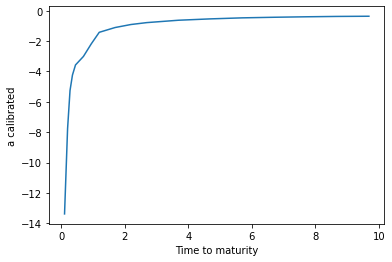

In [66]:
plt.plot(T,a_cal)
plt.xlabel('Time to maturity')
plt.ylabel('a calibrated')

Text(0, 0.5, 'b calibrated')

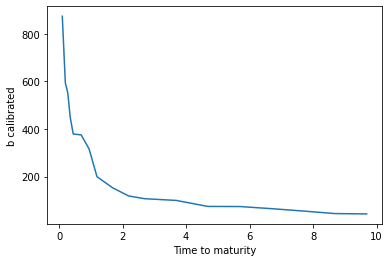

In [67]:
plt.plot(T,b_cal)
plt.xlabel('Time to maturity')
plt.ylabel('b calibrated')

Text(0, 0.5, 'm calibrated')

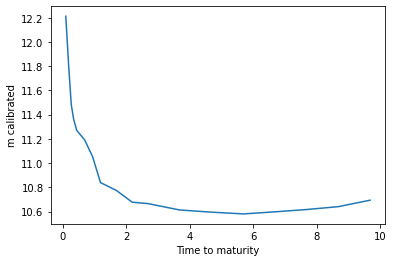

In [24]:
plt.plot(T,m_cal)
plt.xlabel('Time to maturity')
plt.ylabel('m calibrated')

Text(0, 0.5, 'rho calibrated')

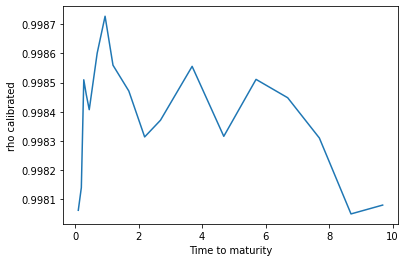

In [25]:
plt.plot(T,rho_cal)
plt.xlabel('Time to maturity')
plt.ylabel('rho calibrated')

Text(0, 0.5, 'sigma calibrated')

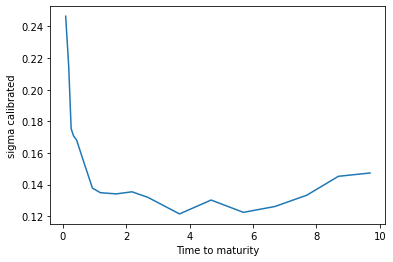

In [41]:
plt.plot(T,sigma_cal)
plt.xlabel('Time to maturity')
plt.ylabel('sigma calibrated')

In [65]:
from tabulate import tabulate
Calibration_par = {'Maturity':T,'a':a_cal,'b':b_cal,'m':m_cal,'rho':rho_cal,'Sigma':sigma_cal}
print(tabulate(Calibration_par,headers='keys',tablefmt='fancy_grid',stralign='center'))

╒════════════╤════════════╤══════════╤═════════╤══════════╤══════════╕
│   Maturity │          a │        b │       m │      rho │    Sigma │
╞════════════╪════════════╪══════════╪═════════╪══════════╪══════════╡
│  0.0986301 │ -13.3853   │ 874.288  │ 12.2119 │ 0.998062 │ 0.246476 │
├────────────┼────────────┼──────────┼─────────┼──────────┼──────────┤
│  0.194521  │  -7.76304  │ 594.646  │ 11.7796 │ 0.99814  │ 0.214718 │
├────────────┼────────────┼──────────┼─────────┼──────────┼──────────┤
│  0.271233  │  -5.25642  │ 551.778  │ 11.482  │ 0.99851  │ 0.175239 │
├────────────┼────────────┼──────────┼─────────┼──────────┼──────────┤
│  0.347945  │  -4.23831  │ 449.594  │ 11.3592 │ 0.99846  │ 0.170724 │
├────────────┼────────────┼──────────┼─────────┼──────────┼──────────┤
│  0.443836  │  -3.57348  │ 378.859  │ 11.2698 │ 0.998407 │ 0.168086 │
├────────────┼────────────┼──────────┼─────────┼──────────┼──────────┤
│  0.693151  │  -3.01404  │ 375.43   │ 11.1914 │ 0.998601 │ 0.152767 │
├─────

# SURFACES SVI

In [36]:
I = np.zeros((51,18))

for i in range(18):
  for j in range(51):
    I[j][i] = (SVI_calibration(np.log(K[j]),a_cal[i],b_cal[i],rho_cal[i],m_cal[i],sigma_cal[i]))**.5 


In [ ]:
x = T
y = K
X,Y = np.meshgrid(x,y)
Z = I
fig = plt.figure()
fig.set_size_inches(8, 6)

ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(Y,X,Z, cmap='hot')


ax.set_ylabel('Time to maturity')
ax.set_xlabel('Strikes')

In [30]:
y = np.zeros((51,18))

for i in range(51):
  y[i] = np.log(K[i]/forwards)

In [31]:
I = np.zeros((51,18))

for i in range(18):
  for j in range(51):
    I[j][i] = (SVI_calibration(np.log(K[j]),a_cal[i],b_cal[i],rho_cal[i],m_cal[i],sigma_cal[i]))**.5 

I = pd.DataFrame(I)

I = I.to_numpy() 

Local_var = np.zeros((50,17))

Local_vol = np.zeros((50,17))

didt = np.zeros((50,17)) 
didy = np.zeros((50,17))
didy2 = np.zeros((50,17)) 

for i in range(1,len(IV)-1):
  for j in range(17):
    didt[i][j] = (I[i][j+1] - I[i][j]) / (T[j+1] - T[j])
    didy[i][j] = (I[i+1][j] - I[i][j]) / (y[i+1][j]-y[i][j]) 
    didy2[i][j] = (I[i+1][j]-I[i-1][j] + 2*I[i][j])/ (y[i+1][j]-y[i][j])**2 
    
    Local_var[i][j] = ((2*T[j]*I[i][j]*didt[i][j] + I[i][j]**2)/((1-2*didy[i][j]*y[i][j]/I[i][j] + 2*(T[j]*I[i][j]*didy[i][j])**2*(-1/8-1/(2*T[j]*I[i][j]**2)+y[i][j]**2) + T[j]*I[i][j]*didy2[i][j] + 2*T[j]*didy[i][j]**2)))

    if Local_var[i][j] >=0:
      Local_vol[i][j] = (Local_var[i][j])**.5

      if Local_vol[i][j] > 5:
        Local_vol[i][j] = (Local_vol[i+1][j] + Local_vol[i-1][j])/2

    else:
      Local_vol[i][j] = (Local_vol[i][j+1] + Local_vol[i][j-1])/2

    


Local2 = pd.DataFrame(Local_vol)


In [34]:
df = Local2.iloc[1:,:]

In [ ]:
x = df.columns
y = df.index
X,Y = np.meshgrid(x,y)
Z = df
fig = plt.figure()
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(Y,X,Z,cmap='viridis')


ax.set_ylabel('Time to maturity')
ax.set_xlabel('Strikes')



# From Local to prices

In [ ]:
def std_MC(S0,K,n,m,t,num):
    brownian=np.zeros([n,m+1])
    time=np.zeros(m+1)
    S=np.zeros([n,m+1])
    z=np.random.normal(0,1,(n,m+1))
    payoff=np.zeros(n)
    int_dw = np.zeros([n,m+1])
    iv=np.zeros([n,m+1])
    int_du = np.zeros([n,m+1])
    y = np.zeros([n,m+1])
    didt = np.zeros([n,m+1])
    didy=np.zeros([n,m+1])
    didy2=np.zeros([n,m+1])
    local_var = np.zeros([n,m+1])
    local_vol = np.zeros([n,m+1])

    for i in range(0,n):
        S[i][0]=S0
        brownian[i][0]=0
        int_du[i][0] = 0
        int_dw[i][0] = 0

        for j in range(0,m):
            iv[i][j] = (SVI_calibration(np.log(S[i][j]),a_cal[num],b_cal[num],rho_cal[num],m_cal[num],sigma_cal[num]))**.5

            y[i][j] = np.log(S[i][j]/forwards[num])
            didt[i][j] = ((SVI_calibration(np.log(S[i][j]),a_cal[num+1],b_cal[num+1],rho_cal[num+1],m_cal[num+1],sigma_cal[num+1]))**2- iv[i][j]) / (T[num+1]-T[num])
            didy[i][j] = ((SVI_calibration(np.log(S[i][j]+0.5),a_cal[num+1],b_cal[num+1],rho_cal[num+1],m_cal[num+1],sigma_cal[num+1]))**2 - iv[i][j]) / (np.log((S[i][j]+0.5)/S0)-np.log(S[i][j]/S0)) 
            didy2[i][j] = ((SVI_calibration(np.log(S[i][j]+0.5),a_cal[num+1],b_cal[num+1],rho_cal[num+1],m_cal[num+1],sigma_cal[num+1]))**2-(SVI_calibration(np.log(S[i][j]-0.5),a_cal[num+1],b_cal[num+1],rho_cal[num+1],m_cal[num+1],sigma_cal[num+1]))**2 + 2*iv[i][j])/ (np.log((S[i][j]+0.5)/S0)-np.log(S[i][j]/S0))**2 

            local_var[i][j] = ((2*T[num]*iv[i][j]*didt[i][j] + iv[i][j]**2)/((1-2*didy[i][j]*y[i][j]/iv[i][j] + 2*(T[num]*iv[i][j]*didy[i][j])**2*(-1/8-1/(2*T[num]*iv[i][j]**2)+y[i][j]**2) + T[num]*iv[i][j]*didy2[i][j] + 2*T[num]*didy[i][j]**2)))
            
            if local_var[i][j] >=0:
              local_vol[i][j] = (local_var[i][j])**.5
    
            else:
              local_vol[i][j] = (abs(local_var[i][j]))**.5     
            
            time[j+1]=time[j]+t/m
            brownian[i][j+1]=brownian[i,j]+z[i,j]*np.sqrt(t/m)
          
            int_dw[i][j+1]=int_dw[i][j]+local_vol[i][j]*(brownian[i][j+1]-brownian[i][j])*np.sqrt(t/m)
            
            
            int_du[i][j+1]= int_du[i][j] + (local_vol[i][j]**2)*t/m

            S[i][j+1]=S[i][0]*(np.exp((-0.5*int_du[i][j])+ int_dw[i][j]))
        print(S[i][m])  
        payoff[i]=np.maximum(S[i][m]-K,0)
 
    return(S,np.mean(payoff))

In [ ]:
std_MC(forwards[5],K[35],1000,100,T[2],2)

#SVI Iker

In [ ]:
I = np.zeros((51,18)) #Implied vols from SVI

for i in range(18):
  for j in range(51):
    I[j][i] = (SVI_calibration(np.log(K[j]),a_cal[i],b_cal[i],rho_cal[i],m_cal[i],sigma_cal[i]))**.5 

I = pd.DataFrame(I)

In [ ]:
y = K
x = T
X,Y = np.meshgrid(x,y)
Z = I
fig = plt.figure()
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(Y,X,Z)

In [ ]:
I = I.to_numpy() 

Local_var = np.zeros((50,17))

Local_vol = np.zeros((50,17)) #Local vols from SVI

didt = np.zeros((50,17)) 
didy = np.zeros((50,17))
didy2 = np.zeros((50,17)) 

for i in range(1,len(IV)-1):
  for j in range(17):
    didt[i][j] = (I[i][j+1] - I[i][j]) / (T[j+1] - T[j])
    didy[i][j] = (I[i+1][j] - I[i][j]) / (y[i+1][j]-y[i][j]) 
    didy2[i][j] = (I[i+1][j]-I[i-1][j] + 2*I[i][j])/ (y[i+1][j]-y[i][j])**2 
    
    Local_var[i][j] = ((2*T[j]*I[i][j]*didt[i][j] + I[i][j]**2)/((1-2*didy[i][j]*y[i][j]/I[i][j] + 2*(T[j]*I[i][j]*didy[i][j])**2*(-1/8-1/(2*T[j]*I[i][j]**2)+y[i][j]**2) + T[j]*I[i][j]*didy2[i][j] + 2*T[j]*didy[i][j]**2)))

    if Local_var[i][j] >=0:
      Local_vol[i][j] = (Local_var[i][j])**.5

      if Local_vol[i][j] > 5:
        Local_vol[i][j] = (Local_vol[i+1][j] + Local_vol[i-1][j])/2

    else:
      Local_vol[i][j] = (Local_vol[i][j+1] + Local_vol[i][j-1])/2

    


Local2 = pd.DataFrame(Local_vol)

In [ ]:
df = Local2.iloc[1:,:]

In [ ]:
fig,ax= plt.subplots(nrows=3,ncols=3,figsize=(12,8),gridspec_kw={'wspace':0.2,'hspace':0.1},sharex='col',sharey='row')


ax[0,0].plot(K[1:50],df[0],label = 'T = 0.1')
ax[0,0].grid()  
ax[0,0].legend(loc='best')

ax[0,1].plot(K[1:50],df[1],label = 'T = 0.19')
ax[0,1].grid()  
ax[0,1].legend(loc='best')

ax[0,2].plot(K[1:50],df[2],label = 'T = 0.27')
ax[0,2].grid()  
ax[0,2].legend(loc='best')

ax[1,0].plot(K[1:50],df[3],label = 'T = 0.35')
ax[1,0].grid()  
ax[1,0].legend(loc='best')

ax[1,1].plot(K[1:50],df[4],label = 'T = 0.44')
ax[1,1].grid()  
ax[1,1].legend(loc='best')

ax[1,2].plot(K[1:50],df[5],label = 'T = 0.69' )
ax[1,2].grid()  
ax[1,2].legend(loc='best')

ax[2,0].plot(K[1:50],df[6],label = 'T = 0.94')
ax[2,0].grid()  
ax[2,0].legend(loc='best')

ax[2,1].plot(K[1:50],df[7],label = 'T = 1.19')
ax[2,1].grid()  
ax[2,1].legend(loc='best')

ax[2,2].plot(K[1:50],df[8],label = 'T = 1.69')
ax[2,2].grid()  
ax[2,2].legend(loc='best')

plt.setp(ax[-1, :], xlabel='Strikes')
plt.setp(ax[:, 0], ylabel=' Local volatility')

In [ ]:
fig,ax= plt.subplots(nrows=3,ncols=3,figsize=(12,8),gridspec_kw={'wspace':0.2,'hspace':0.1},sharex='col',sharey='row')


ax[0,0].plot(K[1:50],df[9],label = 'T = 2.19 ')
ax[0,0].grid()  
ax[0,0].legend(loc='best')

ax[0,1].plot(K[1:50],df[10],label = 'T = 2.68')
ax[0,1].grid()  
ax[0,1].legend(loc='best')

ax[0,2].plot(K[1:50],df[11],label = 'T = 3.68')
ax[0,2].grid()  
ax[0,2].legend(loc='best')

ax[1,0].plot(K[1:50],df[12],label = 'T = 4.68')
ax[1,0].grid()  
ax[1,0].legend(loc='best')

ax[1,1].plot(K[1:50],df[13],label = 'T = 5.7')
ax[1,1].grid()  
ax[1,1].legend(loc='best')

ax[1,2].plot(K[1:50],df[14],label = 'T = 6.7')
ax[1,2].grid()  
ax[1,2].legend(loc='best')

ax[2,0].plot(K[1:50],df[15],label = 'T = 7.69')
ax[2,0].grid()  
ax[2,0].legend(loc='best')

ax[2,1].plot(K[1:50],df[16],label = 'T = 8.69')
ax[2,1].grid()  
ax[2,1].legend(loc='best')

ax[2,2].grid()

plt.setp(ax[-1, :], xlabel='Strikes')
plt.setp(ax[:, 0], ylabel=' Local volatility')

In [ ]:
x = df.columns
y = df.index
X,Y = np.meshgrid(x,y)
Z = df
fig = plt.figure()
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(Y,X,Z)

# SSVI OPTION PRICING

In [ ]:
def SSVI(k,t,params):
  params = gamma, sigma, rho
  var=(sigma**2)*t
  phi=1/(gamma*var)*(1-(1-np.exp(-gamma*var))/(gamma*var))
  return 0.5*var*(1.+rho*phi*k+np.sqrt((phi*k+rho)*(phi*k+rho)+1.-(rho**2)))

def local_var(k,t,params):
    params = gamma, sigma, rho
    var=(sigma**2)*t
    phi=1/(gamma*var)*(1-(1-np.exp(-gamma*var))/(gamma*var))
    eps=0.001

    didk=0.5*var*phi*(phi*k+rho*np.sqrt((phi**2)*(k**2)+2*phi*rho*k+1)+rho)/np.sqrt((phi**2)*(k**2)+2*phi*rho*k+1)
    didk2=0.5*var*(phi**2)*(1-(rho**2))/ (((phi**2)*(k**2) + 2*phi*rho*k + 1)*np.sqrt((phi**2)*(k**2)+2*phi*rho*k+1))
    didt=(SSVI(k,t+eps,params) - SSVI(k,t-eps,params))/(2*eps)
    g_func=(1.-0.5*k*didk/SSVI(k,t+eps,params))*(1.-0.5*k*didk/SSVI(k,t+eps,params)) - 0.25*didk*didk*(0.25 + 1./SSVI(k,t+eps,params)) + 0.5*didk2
    loc_var=didt/g_func
    return loc_var

In [ ]:
sigma, gamma, rho = 0.2, 0.8, -0.7

print("Avoidance of static arbitrage: ", (gamma - 0.25*(1.+np.abs(rho))>0.))
params = gamma, sigma, rho


In [ ]:
def local_price(s0,k,t, params,n,m):
    delta = t / (1.*m)
    S = np.linspace(s0,s0,n)
    time=np.linspace(delta,t,m)
    for i in time:
      sig1=np.sqrt(local_var(np.log(S), i,params))
      S = S*np.exp(-0.5*(sig1**2)*delta + np.sqrt(delta)*sig1*np.random.normal(0,1,n))
    price = np.mean(np.maximum(S-k, 0.))
    return price

In [ ]:
local_price(2558.14,100,0.11,params,100000,1500)

In [ ]:
def exotic_price(s0,k,t,params,n,m,pay):
  delta = t / (1.*m)
  SS = np.linspace(s0,s0,n)
  time=np.linspace(delta,t,m)
  payoff=np.zeros(n)
  payoff[0]=0
  for i in time:
    sig1=np.sqrt(local_var(np.log(SS), i,params))
    SS = SS*np.exp(-0.5*(sig1**2)*delta + np.sqrt(delta)*sig1*np.random.normal(0,1,n))
  for j in range(0,n):
    if SS[j]>=k:
      payoff[j]=pay
    else:
      payoff[j]=0
  price = np.mean(payoff)
  return price

In [ ]:
exotic_price(2800,3100,1,params,10000,1500,100)